# Curso Aprendizaje Automático 

## Tarea Programada 03

### Estudiantes:

- **Carlos Jesus Abarca Murillo**
- **Maria Paula Castillo Espinoza**

---

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import unicodedata
from openpyxl import load_workbook

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans




Inicialmente se cargan y preprocesan los datos del INEC y se preprocesan para que provincia, cantón y distrito estén en su propia columna y sea más fácil hacer join con los datos del OIJ.

In [ ]:
# --- Parámetros ajustables que dependen del archivo ---
XLSX_PATH   = "DatosINEC.xlsx"   # Ruta al archivo INEC convertido a .xlsx
SHEET_NAME  = "Cuadro 22"        # Nombre de la hoja a procesar
HDR_ROW_1   = 6                  # Primera fila del encabezado (1-indexed en Excel)
HDR_ROW_2   = 7                  # Segunda fila del encabezado (1-indexed)
DATA_START  = 9                  # Fila donde arrancan los datos (1-indexed)

# --- Utilidades ---
def norm_text(s: str) -> str:
    #Quita tildes, espacios y pasa a minúsculas.
    if s is None:
        return ""
    s = str(s).strip()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = " ".join(s.split())
    return s.lower()

PROVINCIAS_CR = {
    "san jose", "alajuela", "cartago", "heredia", "guanacaste", "puntarenas", "limon"
}

# --- Carga del libro ---
wb = load_workbook(XLSX_PATH, data_only=True)
if SHEET_NAME not in wb.sheetnames:
    raise ValueError(f"La hoja '{SHEET_NAME}' no existe. Hojas disponibles: {wb.sheetnames}")
ws = wb[SHEET_NAME]

max_row = ws.max_row
max_col = ws.max_column

# --- Construir nombres de columnas desde filas 6 y 7 ---
# Regla:
# - Si hay texto en la fila 7, úsalo.
# - Si no, usa el de la fila 6.
# - Si hay en ambas y no son iguales, concatena.
col_names = {}
for c in range(1, max_col + 1):
    v1 = ws.cell(row=HDR_ROW_1, column=c).value
    v2 = ws.cell(row=HDR_ROW_2, column=c).value

    t1 = (str(v1).strip() if v1 is not None else "")
    t2 = (str(v2).strip() if v2 is not None else "")

    if t2:
        name = t2
    elif t1:
        name = t1
    else:
        name = f"Unnamed_{c}"

    # Si hay ambas y son diferentes y ninguna es vacía, combinar evitando duplicados
    if t1 and t2 and t1 != t2:
        n1 = norm_text(t1)
        n2 = norm_text(t2)
        if n2 not in n1 and n1 not in n2:
            name = f"{t1} - {t2}"

    col_names[c] = name

# Identificar la columna de ubicación (Provincia, cantón y distrito)
loc_col_idx = None
for c, name in col_names.items():
    v = norm_text(name)
    if ("provincia" in v) and ("canton" in v) and ("distrito" in v):
        loc_col_idx = c
        break
if loc_col_idx is None:
    raise RuntimeError("No se encontró la columna de 'Provincia, cantón y distrito' en los encabezados combinados.")

# --- Reconstruir jerarquía por formato (negrita) ---
rows_out = []
curr_prov = None
curr_canton = None

for r in range(DATA_START, max_row + 1):
    cell = ws.cell(row=r, column=loc_col_idx)
    text_raw = cell.value

    # Saltar filas vacías o separadores
    if text_raw is None or str(text_raw).strip() == "":
        continue

    is_bold = bool(cell.font and cell.font.bold)
    txt_norm = norm_text(text_raw)
    text_clean = str(text_raw).strip()

    if is_bold:
        # Si es negrita, puede ser Provincia o Cantón
        # Regla: si es provincia oficial y distinta de la actual -> Provincia.
        # Si es igual a la provincia actual o no es provincia -> Cantón.
        if (txt_norm in PROVINCIAS_CR) and (curr_prov != text_clean):
            curr_prov = text_clean
            curr_canton = None
        else:
            curr_canton = text_clean
        continue  # filas en negrita NO son distritos

    # Si no es negrita => es Distrito, hereda provincia y cantón vigentes
    distrito = text_clean
    prov = curr_prov
    canton = curr_canton

    # Construir el registro con Provincia, Cantón, Distrito + métricas de la fila
    row = {
        "Provincia": prov,
        "Cantón": canton,
        "Distrito": distrito
    }
    for c in range(1, max_col + 1):
        if c == loc_col_idx:
            continue
        row[col_names[c]] = ws.cell(row=r, column=c).value
    rows_out.append(row)

# --- A DataFrame y limpieza ligera ---
df_out = pd.DataFrame(rows_out)

for col in ["Provincia", "Cantón", "Distrito"]:
    if col in df_out.columns:
        df_out[col] = (
            df_out[col]
            .astype("string")
            .str.replace(r"\s+", " ", regex=True)
            .str.strip()
        )

# --- Imputación por MEDIA de columna (manejo de "-") ---
import numpy as np
DASHLIKE = {"-", "–", "—", "−", "‑"}
def to_float_or_nan(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip()
    if s in DASHLIKE or s.lower() in {"na","n/a","nd","n.d.","sd","s/d",""}:
        return np.nan
    s = s.replace("%","").replace("\u00a0"," ").replace(" ", "")
    if "," in s and "." in s:
        s = s.replace(".", "").replace(",", ".")
    elif "," in s:
        s = s.replace(",", ".")
    try:
        return float(s)
    except:
        return np.nan

key_cols = ["Provincia", "Cantón", "Distrito"]
candidate_cols = [c for c in df_out.columns if c not in key_cols]

for col in candidate_cols:
    df_out[col] = df_out[col].apply(to_float_or_nan)
    if df_out[col].notna().any():
        df_out[col] = df_out[col].fillna(df_out[col].mean())
# Quitar columnas completamente vacías y las últimas 3 columnas del archivo ya que no son de valor para este ejercicio
non_empty_ratio = df_out.notna().mean()
keep_cols = [c for c in df_out.columns if (non_empty_ratio[c] > 0.0) or (c in ["Provincia", "Cantón", "Distrito"])]
df_out = df_out.iloc[:, :-3]

# --- 4) Guardar ---
OUT_XLSX = "DatosINEC_procesado.xlsx"
df_out.to_excel(OUT_XLSX, index=False, sheet_name="INEC_Distritos")

print(f"Listo. Guardado en: {OUT_XLSX}")
print(df_out.head(10))


Listo. Guardado en: DatosINEC_procesado.xlsx
  Provincia    Cantón                   Distrito  Unnamed_1  \
0  San José  San José                     Carmen        NaN   
1  San José  San José                     Merced        NaN   
2  San José  San José                   Hospital        NaN   
3  San José  San José                   Catedral        NaN   
4  San José  San José                     Zapote        NaN   
5  San José  San José  San Francisco de Dos Ríos        NaN   
6  San José  San José                      Uruca        NaN   
7  San José  San José               Mata Redonda        NaN   
8  San José  San José                      Pavas        NaN   
9  San José  San José                    Hatillo        NaN   

   Población de 15 años y más  Tasa neta de participación  Tasa de ocupación  \
0                      2431.0                   56.314274          54.792267   
1                      9655.0                   59.243915          56.996375   
2                    

Los datos del OIJ se obtuvieron directamente de la página oficial, se filtraron para obtener solamente los datos de criminalidad del 2011. Una vez que se obtuvieron estos datos, se notó que existían algunos crímenes sin distrito registrado, estos datos para efectos de esta tarea no eran valiosos, por lo que se eliminaron. 

Finalmente, con los datos de criminalidad se construyó una pivot table para obtener la cantidad de crímenes por distrito.

Ahora que se tienen ambos archivos preprocesados se procede a unirlos por distrito, en este caso de decide unirlos por Distrito, Canton y Provincia ya que en ocasiones el nombre del distrito se puede repetir para varios cantones.

In [317]:
# --- Configura los archivos --
PATH_INEC = "DatosINEC_procesado.xlsx"     # archivo INEC ya procesado
PATH_OIJ  = "Delitos2011.xlsx"             # archivo OIJ 2011
SHEET_INEC = "INEC_Distritos"              
SHEET_OIJ  = "Sheet2"                      
OUT_FILE   = "Dataset_Full.xlsx"

# --- Función para normalizar texto (quita tildes, minúsculas, trim) ---
def norm_text(s):
    if pd.isna(s):
        return s
    s = str(s).strip()
    s = " ".join(s.split())
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("utf-8")
    return s.lower()

# --- Cargar ---
df1 = pd.read_excel(PATH_INEC, sheet_name=SHEET_INEC)
df2 = pd.read_excel(PATH_OIJ,  sheet_name=SHEET_OIJ)

# Eliminar columnas sin encabezado
df1 = df1.loc[:, ~df1.columns.str.contains(r'^Unnamed', case=False)]
df2 = df2.loc[:, ~df2.columns.str.contains(r'^Unnamed', case=False)]

# --- Limpieza en llaves de join ---
for col in ["Provincia", "Cantón", "Distrito"]:
    if col in df1.columns: df1[col] = df1[col].apply(norm_text)
    if col in df2.columns: df2[col] = df2[col].apply(norm_text)

# --- Merge por 3 columnas ---
df_join = pd.merge(
    df1, df2,
    on=["Provincia", "Cantón", "Distrito"],
    how="inner",     # se escoje inner para conservar solo aquellas filas que hagan match en ambos archivos         
    suffixes=("_INEC", "_OIJ")
)

# --- Guardar ---
df_join.to_excel(OUT_FILE, index=False)

# --- Resumen rápido ---
print("Filas INEC:", len(df1))
print("Filas OIJ :", len(df2))
print("Filas join:", len(df_join))
print("Guardado en:", OUT_FILE)


Filas INEC: 472
Filas OIJ : 459
Filas join: 410
Guardado en: Dataset_Full.xlsx


En este caso se escgieron las variables socioeconómicas del INEC (población mayor de 15 años, Tasa neta de participación, Tasa de ocupación, Tasa de desempleo abierto, Porcentaje de población económicamente activa y la relaión de dependencia ecónomica) debido a que son las que pueden reflejar las condiciones sociales en las que viven los costarricences y podrían relacionarse con patrones de criminalidad dentro de los distritos.

In [318]:
# Iniciamos leyendo el archivo donde se hizo el Join
df_full = pd.read_excel("Dataset_Full.xlsx", sheet_name="Sheet1")

# Se renombran las columnas para que se más fácil su manipulación
df_full = df_full.rename(columns={
    "Provincia": "Provincia",
    "Cantón": "Canton",
    "Distrito": "Distrito",
    "Población de 15 años y más": "Poblacion15mas",
    "Tasa neta de participación": "TasaParticipacion",
    "Tasa de ocupación": "TasaOcupacion",
    "Tasa de desempleo abierto": "TasaDesempleo",
    "Porcentaje de población económicamente inactiva": "PorcInactivos",
    "Relación de dependencia económica": "RelacionDependencia",
    "Count of SubDelito": "CantidadDelitos"
})

# Se definen los features de importancia
features = [
    "Poblacion15mas",
    "TasaParticipacion",
    "TasaOcupacion",
    "TasaDesempleo",
    "PorcInactivos",
    "RelacionDependencia",
    "CantidadDelitos"
]


X = df_full[features]
# Se escalan los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Se procede a mostrar algunas gráficas para entender mejor el comportamiento del set de datos:

/var/folders/v4/f5d48x0s18bb_98hvqj9sszr0000gn/T/ipykernel_45409/2728016942.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_full, x="Provincia", y="CantidadDelitos", estimator=sum, ci=None)


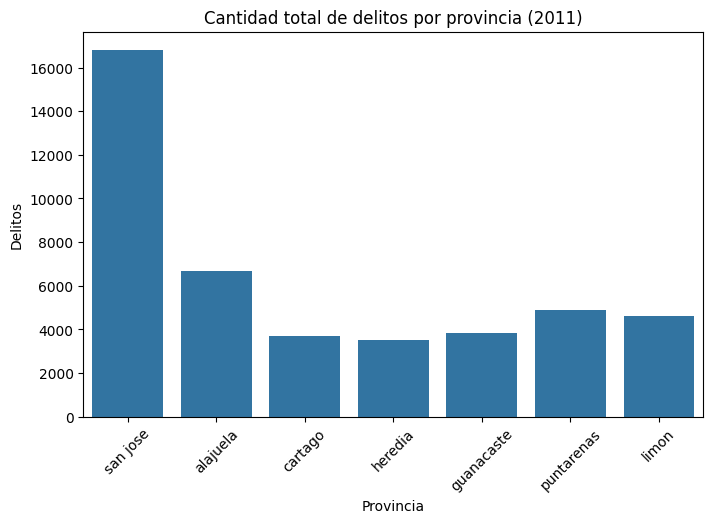

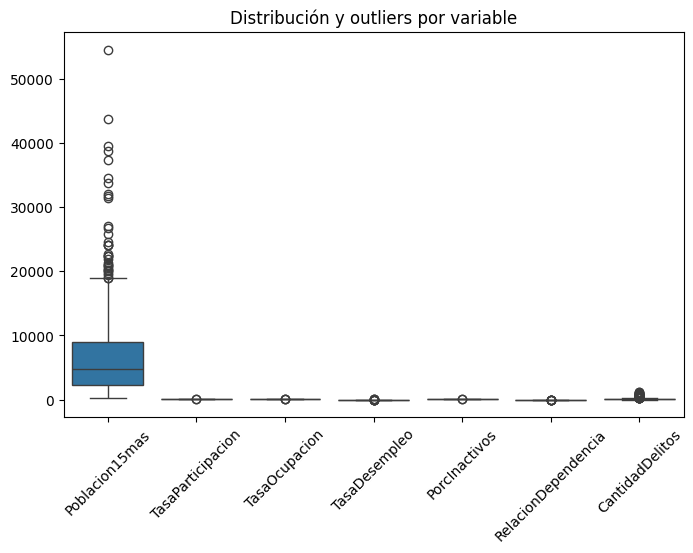

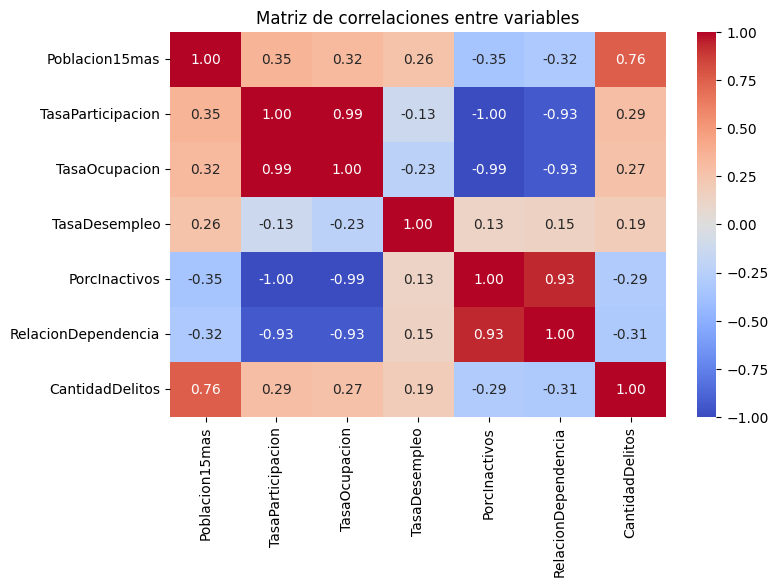

In [ ]:
# Se muestra el conteo de delitos por provincia
plt.figure(figsize=(8,5))
sns.barplot(data=df_full, x="Provincia", y="CantidadDelitos", estimator=sum, ci=None)
plt.title("Cantidad total de delitos por provincia (2011)")
plt.xticks(rotation=45)
plt.ylabel("Delitos")
plt.show()

# Se generan boxplots para evaluar si existen muchos outliers en el set de datos
plt.figure(figsize=(8,5))
sns.boxplot(data=df_full[features])
plt.xticks(rotation=45)
plt.title("Distribución y outliers por variable")
plt.show()

# Se genera una matriz de correlaciones para visualizar cómo se comportan los datos
plt.figure(figsize=(8,5))
corr = df_full[features].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlaciones entre variables")
plt.show()

Seguidamente se inicia evaluando K-Means con k=10

In [320]:
# Inicialmente probamos con 10 clusters (ajustaremos K más adelante)
k10 = 10
kmeans10 = KMeans(n_clusters=k10, random_state=42, n_init=10)
labels10 = kmeans10.fit_predict(X_scaled)
df_full["Cluster_KMeans"] = labels10

# Centroides en escala original
centroids10_scaled = kmeans10.cluster_centers_
centroids10_orig = scaler.inverse_transform(centroids10_scaled)

centroids10_df = pd.DataFrame(centroids10_orig, columns=features)
centroids10_df["Cluster"] = range(k10)

print("Centroides con K=10 (en escala original):")
print(centroids10_df.round(3))

Centroides con K=10 (en escala original):
   Poblacion15mas  TasaParticipacion  TasaOcupacion  TasaDesempleo  \
0        3594.587             51.003         49.943          2.082   
1        4206.915             47.576         45.503          4.366   
2       22184.062             58.415         56.430          3.392   
3        2795.273             44.354         43.306          2.368   
4        4656.981             54.229         52.305          3.600   
5        5300.588             58.801         57.465          2.268   
6       35810.000             54.030         51.763          4.207   
7        3166.778             38.367         36.547          4.710   
8       14146.136             56.908         54.976          3.394   
9       14553.625             50.362         48.315          4.064   

   PorcInactivos  RelacionDependencia  CantidadDelitos  Cluster  
0         48.997                1.626           37.347        0  
1         52.424                1.900           43.404 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ahora se va a emplear el método del codo para ver si el K que se escogió es el más apropiado o si existe otro mejor.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

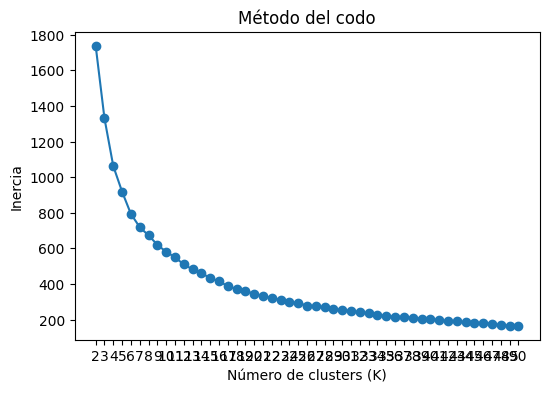

In [321]:
#Se define la cantidad de cluster que vamos a probar
Ks = range(2, 51)   # probamos de 2 a 50 clusters
inertias = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker="o")
plt.title("Método del codo")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")
plt.xticks(Ks)
plt.show()


A partir del gráfico anterior se escoge K=10 para entrenar en modelo porque a partir de ahí es donde se empieza a notar una disminución en la caida de la inercia. Se vuelve a entrenar el modelo y se calculan los centroides:

In [322]:
# Reentrenar con K=4
k3 = 3
kmeans3 = KMeans(n_clusters=k3, random_state=42, n_init=10)
labels3 = kmeans3.fit_predict(X_scaled)
df_full["Cluster_KMeans_4"] = labels3

# Centroides en escala original
centroids3_scaled = kmeans3.cluster_centers_
centroids3_orig = scaler.inverse_transform(centroids3_scaled)

centroids3_df = pd.DataFrame(centroids3_orig, columns=features)
centroids3_df["Cluster"] = range(k3)

print("Centroides con K=3 (en escala original):")
print(centroids3_df.round(3))


Centroides con K=3 (en escala original):
   Poblacion15mas  TasaParticipacion  TasaOcupacion  TasaDesempleo  \
0       22772.128             56.101         54.080          3.614   
1        4075.634             45.521         44.024          3.297   
2        6114.754             54.937         53.385          2.843   

   PorcInactivos  RelacionDependencia  CantidadDelitos  Cluster  
0         43.899                1.313          492.553        0  
1         54.479                2.048           43.530        1  
2         45.063                1.412           68.940        2  


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Seguidamente se le va a aplicar el algoritmo de clustering DBSCAN a los datos. Inicialmente se grafica el k-dist para escoger el eps optimizado. Como nota adicional para este paso se decidió utilizar MinMaxScaler en vez del StandardScaler para evaluar si DBSCAN podía generar más de un cluster.

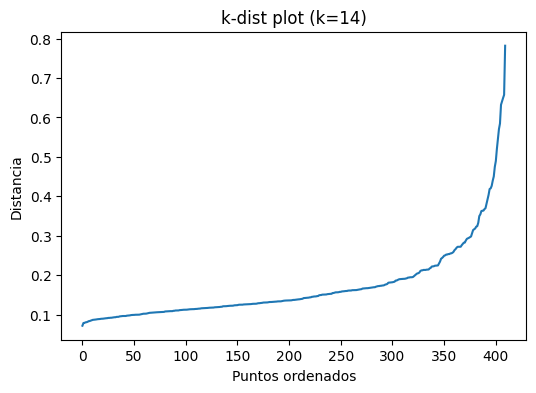

Candidatos eps (percentiles 85/90/95): [0.2428086  0.27958874 0.36572768]


In [323]:
min_samples = 14  # regla: ~2 * número de features


scaler_mm = MinMaxScaler()              
X_scaled_mm = scaler_mm.fit_transform(X)

# Se entrena un modelo de vecinos mas cercanos con los datos escalados
nn = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled_mm)

# Calculamos la distancia a los vecinos más cercanos
distances, _ = nn.kneighbors(X_scaled_mm)
kdist = np.sort(distances[:, -1])  # distancia al vecino #min_samples

# Graficamos el k-dist plot
plt.figure(figsize=(6,4))
plt.plot(kdist)
plt.title(f"k-dist plot (k={min_samples})")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia")
plt.show()

p = np.percentile(kdist, [85, 90, 95])
print("Candidatos eps (percentiles 85/90/95):", p)


Basado en esta curva se procede a escoger un eps=0.3 ya que es aproximadamente donde la curva empieza a subir con mayor fuerza.

In [324]:
# Hiperparámetros de DBSCAN: eps lo sacamos de la curva de k-plot y min_samples sale de la regla 2*num de features
eps = 0.3  # prueba también con 2.0
min_samples = 14

# Se entrena el DBSCAN con los datos ya escalados
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = dbscan.fit_predict(X_scaled_mm)

# Guardar las etiquetas en tu DataFrame
df_full["Cluster_DBSCAN"] = labels_db

# Conteo de clusters
unique, counts = np.unique(labels_db, return_counts=True)
print("Distribución DBSCAN:", dict(zip(unique, counts)))


Distribución DBSCAN: {np.int64(-1): np.int64(13), np.int64(0): np.int64(397)}


De lo anterior se concluye que con DBSCAN se detectaron apenas 2 clusters, donde n=16 se consideran ruido y n=394 se consideraron parte del mismo cluster. 

Ahora que se tienen 3 soluciones del método se aplica el coeficiente de Silhouette a las 3 soluciones anteriores. Para este caso y por fines didácticos se va a utilizar eps=0.1 en DBSCAN para que se genere más de un cluster y poder comparar con Silhoutte.

In [325]:
# --- Silhouette para k=10 ---
sil10 = silhouette_score(X_scaled, labels10)
print("Silhouette (K-Means, K=10):", round(sil10, 3))

# --- Silhouette para k=4 ---
sil3 = silhouette_score(X_scaled, labels3)
print("Silhouette (K-Means, K=3):", round(sil3, 3))

# --- Silhouette para DBSCAN ---
labels_db = df_full["Cluster_DBSCAN"].to_numpy()

# válido solo si hay >=2 clusters distintos (excluyendo ruido -1)
eps01 = 0.1
# Se entrena el DBSCAN con los datos ya escalados
dbscan = DBSCAN(eps=eps01, min_samples=min_samples)
labels_db_01 = dbscan.fit_predict(X_scaled_mm)

# Guardar las etiquetas en tu DataFrame
df_full["Cluster_DBSCAN_01"] = labels_db_01
if len(set(labels_db_01)) > 1 and len(set(labels_db_01)) != (1 + (-1 in labels_db_01)):
    sil_db_01 = silhouette_score(X_scaled_mm[labels_db_01 != -1], labels_db_01[labels_db_01 != -1])
    print("Silhouette (DBSCAN, sin ruido):", round(sil_db_01, 3))
    # Conteo de clusters
    unique_01, counts_01 = np.unique(labels_db_01, return_counts=True)
    print("\nDistribución DBSCAN01:", dict(zip(unique_01, counts_01)))
else:
    print("Silhouette (DBSCAN): no aplicable (solo un cluster o todo ruido)")

Silhouette (K-Means, K=10): 0.266
Silhouette (K-Means, K=3): 0.341
Silhouette (DBSCAN, sin ruido): 0.466

Distribución DBSCAN01: {np.int64(-1): np.int64(262), np.int64(0): np.int64(117), np.int64(1): np.int64(31)}


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


A partir de los datos anteriores se pueden establecer 4 conclusiones:

- El algoritmo K-Means mostró un mejor desempeño con un número reducido de clusters. Inicialmente se utilizaron K=10, y el método del codo permitió optimizar a K=3 mejorando así el coeficiente de Silhoutte lo que indica que los distritos se agrupan de manera más coherente.
- DBSCAN mostró un desempeño superior en términos de cohesión y separación, aunque con un costo alto en términos de ruido. Con eps=0.1 y min_samples = 14, DBSCAN generó dos clusters reales (117 y 31 distritos) y clasificó 262 distritos como outliers. A pesar de la gran cantidad de ruido, el coeficiente de Silhouette alcanzó 0.444, evidenciando que los clusters detectados son más compactos y mejor separados que los formados por K-Means. Este resultado refuerza que el valor de eps no necesariamente coincide con el "codo" del k-dist plot y que DBSCAN es muy sensible a este parámetro.
- La comparación de DBSCAN logró una mejor calidad de clustering frente a K-Means. DBSCAN obtuvo 0.466 comparado contra los valores de 0.266 y 0.341 lo que sugiere que los distritos muestran estructuras más adecuadas a metodos basados en densidad que a metodos con clusters esféricos.
- Para este caso la combinación de métodos aporta una visión más realista del problema. K-Means puede enseñar una partición clara y facil de interpretar en un análisis exploratorio. DBSCAN por otra parte permitió identificar outliers y descubrir estructuras más densas y bien separadas.

### Descripción del problema y Objetivo

El problema central de este trabajo es analizar cómo se distribuyen los delitos en los distritos del país y como se relacionan estas cifras con la realidad socioeconómica de los mismos. El objetivo es aplicar diferentes técnicas de clustering como K-Means y DBSCAN para poder identificar grupos de distritos con patrones similares. Esto permite explorar la relación entre criminalidad, empleo, participación económica e inactividad.

### Descripción y cita de los datos

Se utilizaron dos fuentes principales de datos:
- El Censo Nacional de Población y Vivienda 2011 del INEC, del cual se extrajeron variables socioeconómicas como población de 15 años y más, tasas de participación, ocupación, desempleo, porcentaje de inactividad y relación de dependencia económica.
- El registro de denuncias por delitos del OIJ en 2011, que fue procesado y agregado a nivel de distrito para calcular la variable “Cantidad de Delitos”.
Estas bases de datos se unieron mediante la llave de provincia, cantón y distrito, generando un conjunto de datos con más de 400 distritos y al menos 7 variables relevantes para el análisis.

### Referencias

[1] Instituto Nacional de Estadísticas y Censos (INEC), Censo 2011: Indicadores económicos, según provincia, cantón y distrito. San José, Costa Rica: INEC, 2011. [En línea]. Disponible en: https://admin.inec.cr/sites/default/files/media/reempleocenso2011-22.xls_2.xls

[2] Organismo de Investigación Judicial (OIJ), Estadísticas policiales. San José, Costa Rica: OIJ, 2018. [En línea]. Disponible en: https://sitiooij.poder-judicial.go.cr/index.php/apertura/transparencia/estadisticas-policiales